In [1]:
!kaggle datasets download -d sulianova/cardiovascular-disease-dataset


  0%|          | 0.00/742k [00:00<?, ?B/s]
100%|##########| 742k/742k [00:00<00:00, 1.25MB/s]
100%|##########| 742k/742k [00:00<00:00, 1.25MB/s]


In [2]:
!WinRAR.exe x .\cardiovascular-disease-dataset.zip .\dataset\

In [3]:
!rm cardiovascular-disease-dataset.zip

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('dataset/cardio_train.csv', delimiter=';')

In [3]:
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


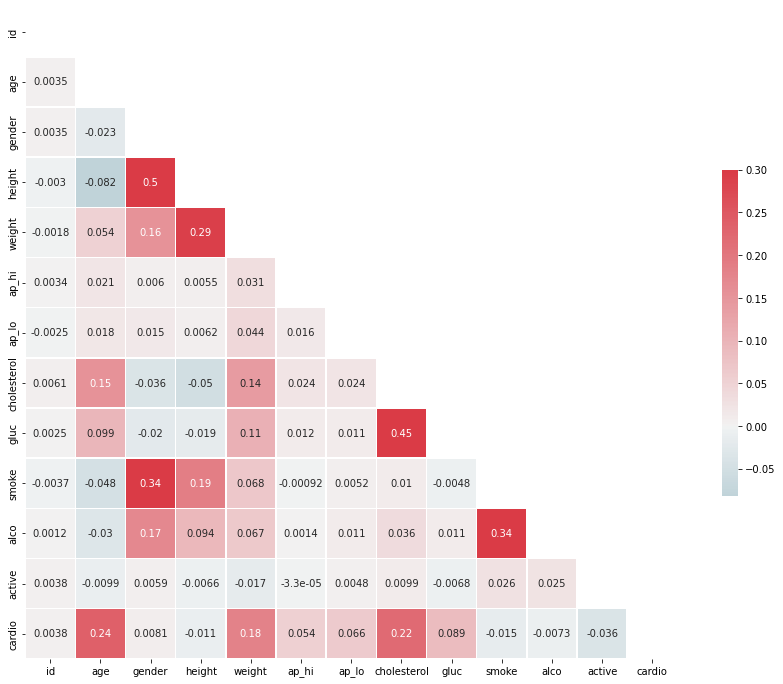

In [7]:
import seaborn as sb
import matplotlib.pyplot as plt
correl = data.corr()
cmap = sb.diverging_palette(220, 10, as_cmap = True)

mask = np.zeros_like(correl, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (16, 12))

sb.heatmap(correl, mask = mask, cmap = cmap, vmax = 0.3, center = 0,annot = True, square = True, linewidths = 0.5, cbar_kws = {"shrink": .5});

<AxesSubplot:title={'center':'Distribution of Genders (1 - Female; 2 - Male)'}, xlabel='Gender', ylabel='Number of Occurences'>

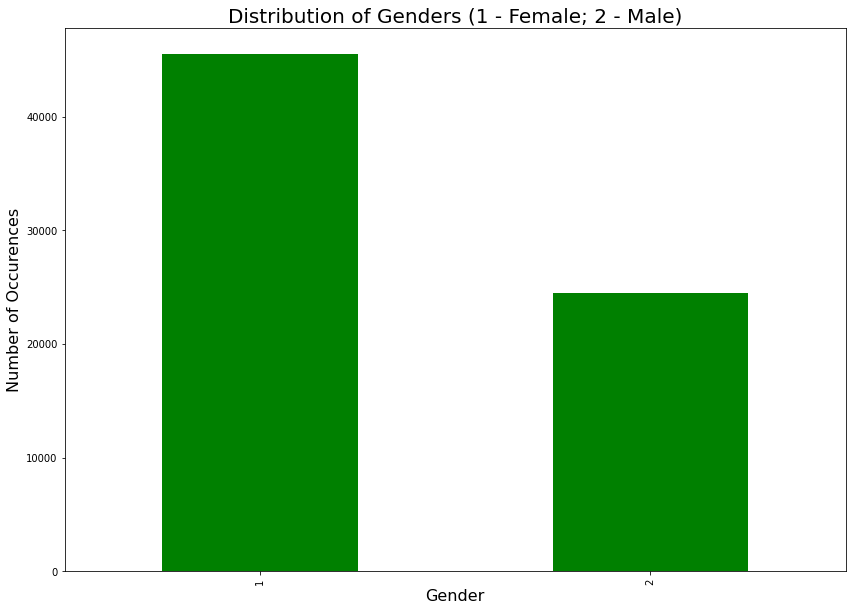

In [9]:
# Gender Distribution
fig, ax = plt.subplots(figsize = (14, 10))
ax.set_title('Distribution of Genders (1 - Female; 2 - Male)', fontsize = 20)
ax.set_xlabel("Gender", fontsize = 16)
ax.set_ylabel("Number of Occurences", fontsize = 16)
data["gender"].value_counts().plot(ax = ax, kind = "bar", color = "green")

<AxesSubplot:title={'center':'Distribution of Heights'}, xlabel='Height in cm', ylabel='Number of Occurences'>

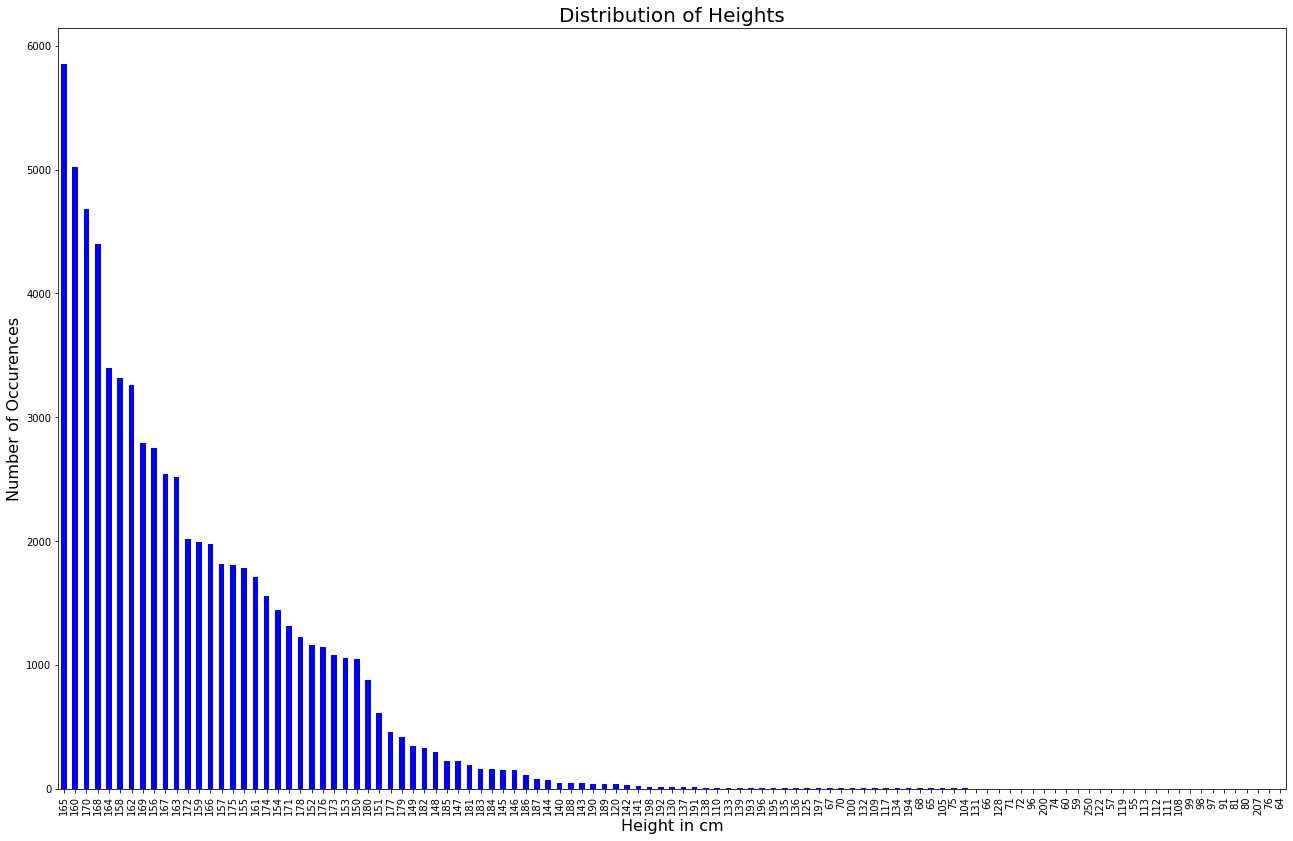

In [10]:
# Height Distribution (Ordered)
fig, ax = plt.subplots(figsize = (22, 14))
ax.set_title('Distribution of Heights', fontsize = 20)
ax.set_xlabel("Height in cm", fontsize = 16)
ax.set_ylabel("Number of Occurences", fontsize = 16)
data["height"].value_counts().plot(ax = ax, kind = "bar", color = "blue")

In [5]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [6]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="gini"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''

        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [8]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.1)

In [ ]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

In [ ]:
Y_pred = classifier.predict(X_test) 
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

In [ ]:
from winsound import Beep
Beep(1000, 1000)